# Configuration du notebook

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [25]:
# Chargement des données
X_train = pd.read_csv("./../data/X_train_update.csv")
y_train = pd.read_csv("./../data/Y_train_CVw08PX.csv")
X_test = pd.read_csv("./../data/X_test_update.csv")

# Exploration des données

In [26]:
def data_info(df, name):
    df.info()
    print("\n")
    display(df.describe())
    print("\n")


## Description de X_train

In [27]:
data_info(X_train, "X_train")

print("NaN values in X_train")
X_train_nan = X_train.isna().sum()
print(X_train_nan)
print("\n")

print("Nan values ratio in X_train", X_train_nan / len(X_train))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84916 entries, 0 to 84915
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   84916 non-null  int64 
 1   designation  84916 non-null  object
 2   description  55116 non-null  object
 3   productid    84916 non-null  int64 
 4   imageid      84916 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 3.2+ MB




,Unnamed: 0,productid,imageid
count,84916.000000,8.491600e+04,8.491600e+04
mean,42457.500000,2.555468e+09,1.152691e+09
std,24513.282066,1.588656e+09,1.751427e+08
min,0.000000,1.839120e+05,6.728400e+04
25%,21228.750000,6.760519e+08,1.056269e+09
50%,42457.500000,3.190506e+09,1.213354e+09
75%,63686.250000,3.995599e+09,1.275646e+09
max,84915.000000,4.252012e+09,1.328824e+09




NaN values in X_train
Unnamed: 0         0
designation        0
description    29800
productid          0
imageid            0
dtype: int64


Nan values ratio in X_train Unnamed: 0     0.000000
designation    0.000000
description    0.350935
productid      0.000000
imageid        0.000000
dtype: float64


Conformément à la description des données, seule la description est optionnelle, on remarque que le jeu de données est complet et que c'est la seule variable avec des valeurs nulles.

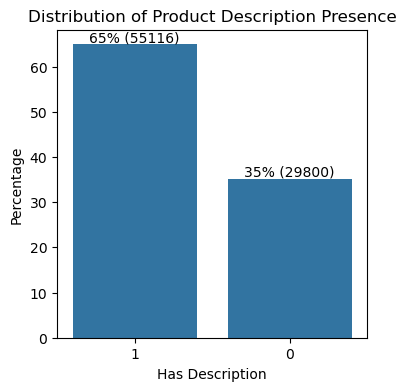

In [38]:
# Dichotomisation de la présence de description dans X_train
X_train['has_description'] = X_train['description'].notna().astype(int)

abs_values = X_train['has_description'].value_counts(ascending=False)
rel_values = X_train['has_description'].value_counts(ascending=False, normalize=True).values * 100
labels = [f'{p[1]:.0f}% ({p[0]})' for p in zip(abs_values, rel_values)]

# Affichage de la distribution de has_description
plt.figure(figsize=(4, 4))
ax = sns.countplot(data=X_train, x='has_description', order=X_train['has_description'].value_counts().index, stat='percent')
ax.bar_label(container=ax.containers[0], labels=labels)

plt.title('Distribution of Product Description Presence')
plt.xlabel('Has Description')
plt.ylabel('Percentage')
plt.show()

Il y a plus de produits avec une description (65 %) que de produits sans description (35%) malgré le caractère optionnel de la description. On peut supposer que cela est dû à l'importance de la description de l'article pour favoriser sa vente en plus de sa catégorisation. En effet, la description fournit d'autres éléments discriminant pour un produit dans le cadre de la recherche via un moteur parmi de nombreux produits.

## Description de y_train

In [29]:
data_info(y_train, "y_train")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84916 entries, 0 to 84915
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Unnamed: 0   84916 non-null  int64
 1   prdtypecode  84916 non-null  int64
dtypes: int64(2)
memory usage: 1.3 MB




,Unnamed: 0,prdtypecode
count,84916.000000,84916.000000
mean,42457.500000,1773.219900
std,24513.282066,788.179885
min,0.000000,10.000000
25%,21228.750000,1281.000000
50%,42457.500000,1920.000000
75%,63686.250000,2522.000000
max,84915.000000,2905.000000


In [30]:
# Nombre de valeurs uniques dans y_train
print("Unique values in y_train")
print(y_train.nunique())

Unique values in y_train
Unnamed: 0     84916
prdtypecode       27
dtype: int64


Il existe 27 classes de produits distinctes dans le jeu de données d'apprentissage.

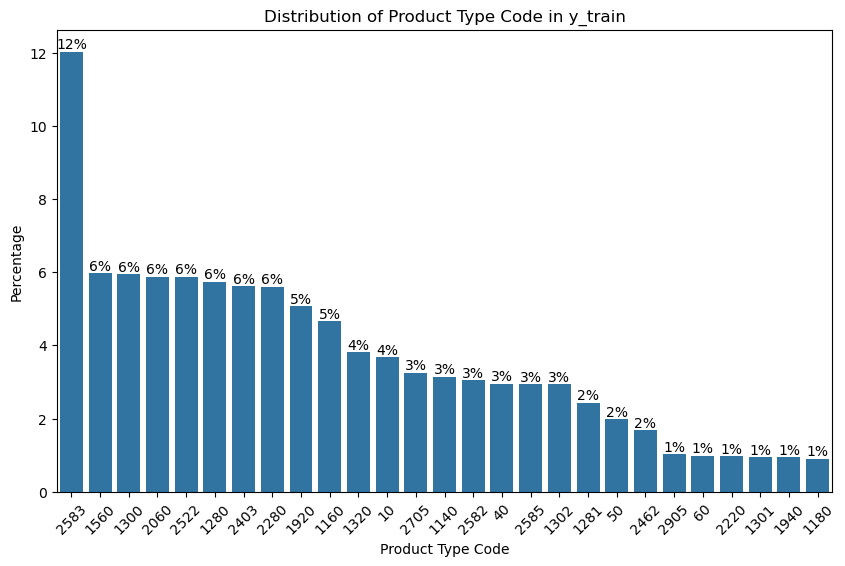

In [36]:
abs_values = y_train['prdtypecode'].value_counts(ascending=False)
rel_values = y_train['prdtypecode'].value_counts(ascending=False, normalize=True).values * 100
labels = [f'{p[1]:.0f}%' for p in zip(abs_values, rel_values)]

# Histogramme de la distribution des codes de type de produit dans y_train
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=y_train, x='prdtypecode', order=y_train['prdtypecode'].value_counts().index, stat='percent')
ax.bar_label(container=ax.containers[0], labels=labels)

plt.title('Distribution of Product Type Code in y_train')
plt.xlabel('Product Type Code')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.show()

Le jeu de données n'est pas équilibré :
- la classe 2583 est plus représentée que les autres avec 12% du jeu de données
- les classes 1560, 1300, 2060, 2522, 1280, 2403, 2280 suivent ensuite avec 6% chacune seulement
- les classes les moins représentées (2905, 60, 2220, 1301, 1940, 1180) représentent quant à elles 1% chacune

## Analyse croisée des variables disponibles

### Analyse croisée entre la présence de description du produit et la catégorie du produit


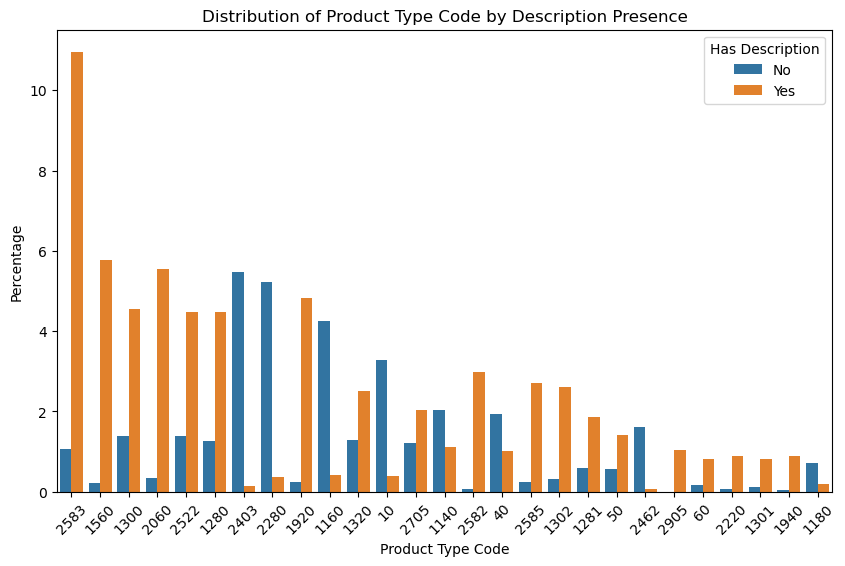

In [40]:
# Affichage de la distribution des codes de type de produit en fonction de la présence de description
plt.figure(figsize=(10, 6))
sns.countplot(data=y_train, x='prdtypecode', hue=X_train['has_description'], order=y_train['prdtypecode'].value_counts().index, stat='percent')
plt.title('Distribution of Product Type Code by Description Presence')
plt.xlabel('Product Type Code')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.legend(title='Has Description', loc='upper right', labels=['No', 'Yes'])
plt.show()

La répartition de produits avec ou sans description n'est pas homogène entre les catégories de produit par rapport au ratio moyen du jeu de données (65% avec et 35% sans description).
Certains produits comme 2403 contiennent majoritairement des produits non décrits alors que d'autres comme 1560 contiennent majoritairement des produits décrits.

### Analyse de la variable designation